Spam Detection v4


In [123]:
# !pip install langdetect
# !pip install faker
# !pip install pytorch_lightning

from google.colab import drive
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
import time

import random
import unicodedata
import string
from langdetect import detect, DetectorFactory
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import random_split, Dataset, DataLoader

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from nltk.stem import WordNetLemmatizer
import nltk
import re

import pytorch_lightning as pl
import torchmetrics

# from sklearn.metrics import classification_report, multilabel_confusion_matrix

from pylab import rcParams
from matplotlib import rc
from torchmetrics import AUROC, Accuracy

torch.manual_seed(42)
np.random.seed(42)



In [124]:
# Cargar el dataset
csv_path = './gpdb.csv'
dataset = pd.read_csv(csv_path, delimiter=';')
dataset = dataset.dropna(subset=['description'])

num_registros = len(dataset)
print(f'Número total de registros: {num_registros}')

rejected_samples = dataset[dataset['status_id'] == 6]
approved_samples = dataset[dataset['status_id'] == 1]

print(f'Número total de registros aprobados: {len(approved_samples)}')
print(f'Número total de registros rechazados: {len(rejected_samples)}')

approved_samples_trimmed = approved_samples.sample(n=len(rejected_samples), random_state=42)

print(f'Número total de registros Aprobados random: {len(approved_samples_trimmed)}')

# Merge registers
extended_dataset = pd.concat([approved_samples_trimmed, rejected_samples])

extended_csv_path = './equal_gpdb.csv'
extended_dataset.to_csv(extended_csv_path, sep=';', index=False)

print(f'Número total de registros después de agregar: {len(extended_dataset)}')
print(f'El dataset extendido se ha guardado en: {extended_csv_path}')


<ipython-input-124-2d5bd7ae938a>:3: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(csv_path, delimiter=';')


Número total de registros: 76707
Número total de registros aprobados: 53188
Número total de registros rechazados: 8351
Número total de registros Aprobados random: 8351
Número total de registros después de agregar: 16702
El dataset extendido se ha guardado en: ./equal_gpdb.csv


In [125]:
extended_dataset[["status_id", "description"]]

,status_id,description
65271,1,TFT Strategy Analyzer is a powerful tool desig...
9306,1,I want to collect a body of data to train a ne...
10004,1,Going to be taking data from my past games and...
15992,1,ERQ Organisation Page is a small website which...
36905,1,League Director
...,...,...
76623,6,This product is a Discord Notification bot tha...
76642,6,to link a riot account with my discord bot to ...
76664,6,Hello there !\r\n\r\nThe app is used for a Val...
76673,6,the lol-mun-chol is communication website for ...


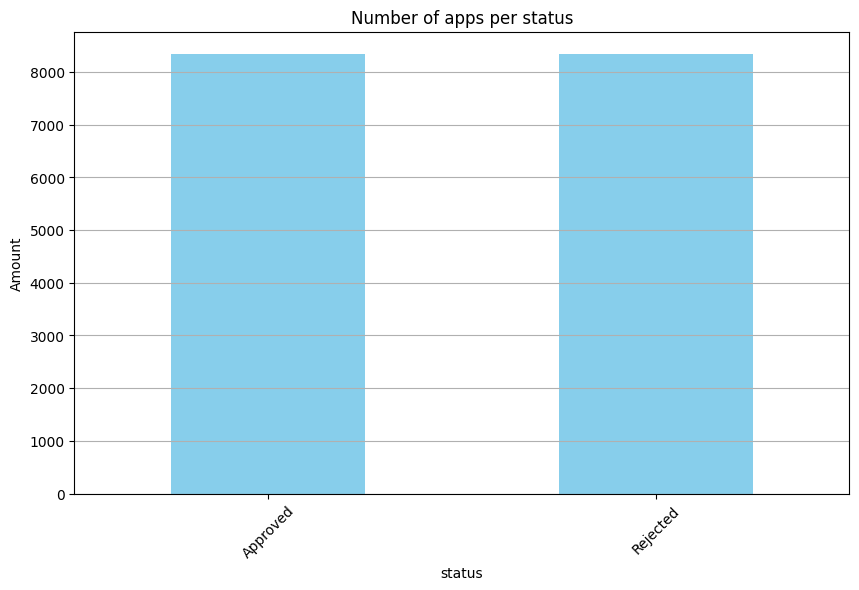

In [126]:
# Contar el número de registros para cada estado
conteo_por_estado = extended_dataset['status_id'].value_counts()

# Mapear los valores de status_id a etiquetas deseadas
etiquetas_estado = {1: 'Approved', 6:'Rejected'}

# Crear el gráfico de barras con etiquetas personalizadas
plt.figure(figsize=(10, 6))
conteo_por_estado.rename(index=etiquetas_estado).plot(kind='bar', color='skyblue')

# Personalizar el gráfico
plt.title('Number of apps per status')
plt.xlabel('status')
plt.ylabel('Amount')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Mostrar el gráfico
plt.show()


In [127]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
from langdetect import detect, LangDetectException

nltk.download('punkt')
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('omw-1.4')

# Function to detect if a string is a UUID
def is_uuid(s):
    pattern = re.compile(r'^[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}$', re.I)
    return bool(pattern.match(s))

# Function to detect if a string contains "http://" or "https://" URLs
def contains_http_or_https(text):
    return bool(re.search(r'https?://', text))

# Function to detect if a string contains only numbers
def contains_only_numbers(text):
    return bool(re.match(r'^[0-9]+$', text))

# Function to filter out descriptions based on the criteria
def should_filter(description):
    return (not description or len(description) < 5 or
            is_uuid(description) or
            contains_http_or_https(description) or
            contains_only_numbers(description))

def lemmatize(description, target_language='en'):
    try:
        if should_filter(description):
            return ''

        lang = detect(description)
        if lang != 'en':
            return ''

        tokens = word_tokenize(description.lower())
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(lemmatized_tokens)
    except LangDetectException as e:
        print(f"Error detecting language: {e}\nDescription: {description}")
        return ''

# Apply lemmatization to the dataset
extended_dataset['lemmatized_description'] = extended_dataset['description'].apply(lemmatize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Error detecting language: No features in text.
Description: 16/11/2017
Error detecting language: No features in text.
Description: ㅇㅁㄴㅇㅁㄴ
Error detecting language: No features in text.
Description: ㄴㅇㄹㄴㄹㅇ


In [128]:
result_set = extended_dataset[extended_dataset['lemmatized_description'] != '']

# print(result_set['lemmatized_description'])
print(result_set.iloc[0]['lemmatized_description'])
print('--------------')
print(result_set.iloc[0]['description'])

tft strategy analyzer is a powerful tool designed for my personal research purpose in the realm of teamfight tactic ( tft ) . this application is intended solely for my personal use a i delve into the intricacy of tft gameplay and strategy development . product feature tft strategy analyzer serf the following key function to support my personal research endeavor : statistical analysis : it offer in-depth statistical analysis of tft game data , enabling me to gain insight into gameplay pattern and strategic trend . this feature aid in uncovering the most effective strategy and tactic . recommendation : the application provides real-time recommendation during gameplay , offering valuable insight into my current tft match . these recommendation are generated through machine learning technique based on data from other tft player using the same champion . this application is not intended for commercial use or public distribution . it is purely for personal research , analysis , and experime

In [129]:
#lemmatized_description is less than 100 characters
# result_set = result_set[result_set['lemmatized_description'].str.len() >= 100]

filtered_dataset = result_set[['lemmatized_description', 'status_id']].copy()

In [130]:
# Guardar el dataset extendido
lema_csv_path = './lema_gpdb_ascii.csv'
filtered_dataset.to_csv(lema_csv_path, sep=';', index=False, columns=['lemmatized_description', 'status_id'])

print(f'Número total de registros después de agregar: {len(filtered_dataset)}')
print(f'El dataset extendido se ha guardado en: {lema_csv_path}')

Número total de registros después de agregar: 12330
El dataset extendido se ha guardado en: ./lema_gpdb_ascii.csv


In [131]:
filtered_dataset

,lemmatized_description,status_id
65271,tft strategy analyzer is a powerful tool desig...,1
9306,i want to collect a body of data to train a ne...,1
10004,going to be taking data from my past game and ...,1
15992,erq organisation page is a small website which...,1
36905,league director,1
...,...,...
76553,hi ! i 'm dltv.org developer . i want to test ...,6
76623,this product is a discord notification bot tha...,6
76642,to link a riot account with my discord bot to ...,6
76664,hello there ! the app is used for a valorant c...,6


In [132]:
# Cargar el dataset
clean_dataset = pd.read_csv(lema_csv_path, delimiter=';')

num_registros = len(clean_dataset)
print(f'Number of registers: {num_registros}')

Number of registers: 12330


In [134]:
clean_dataset['status_id'] = clean_dataset['status_id'].replace(6, 0)

clean_dataset

,lemmatized_description,status_id
0,tft strategy analyzer is a powerful tool desig...,1
1,i want to collect a body of data to train a ne...,1
2,going to be taking data from my past game and ...,1
3,erq organisation page is a small website which...,1
4,league director,1
...,...,...
12325,hi ! i 'm dltv.org developer . i want to test ...,0
12326,this product is a discord notification bot tha...,0
12327,to link a riot account with my discord bot to ...,0
12328,hello there ! the app is used for a valorant c...,0


In [147]:
def prepare_data_for_bert(df, tokenizer, max_length=512):
    input_ids = []
    attention_masks = []

    for text in df['lemmatized_description']:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(df['status_id'].values)

    return input_ids, attention_masks, labels

In [166]:
import torch
from torch.optim import AdamW
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.nn import functional as F
import torch.nn as nn
from transformers import BertForSequenceClassification

class BertWithMLP(nn.Module):
    def __init__(self, num_labels=2, hidden_size=768, mlp_hidden_size=256):
        super(BertWithMLP, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
        self.dropout = nn.Dropout(p=0.3)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, mlp_hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(mlp_hidden_size, num_labels)
        )

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.mlp(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.bert.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else logits

def freeze_bert_layers(model, num_layers_to_freeze=10):
    """
    Freezes the specified number of layers in the BERT model.
    """
    modules = list(model.bert.bert.encoder.layer)
    for layer in modules[:num_layers_to_freeze]:
        for param in layer.parameters():
            param.requires_grad = False

def unfreeze_all_bert_layers(model):
    """
    Unfreezes all layers in the BERT model.
    """
    for param in model.bert.bert.parameters():
        param.requires_grad = True

def create_model_with_frozen_bert(freeze_bert=True, num_labels=2, num_layers_to_freeze=10):
    model = BertWithMLP(num_labels=num_labels)
    freeze_bert_layers(model, num_layers_to_freeze)
    if freeze_bert:
        freeze_bert_layers(model, num_layers_to_freeze)
    else:
        unfreeze_all_bert_layers(model)

    return model

def train_model(model, train_dataloader, validation_dataloader, epochs=100, patience=20, lr=1e-6, eps=1e-8, weight_decay=0.1):
    optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=lr, eps=eps, weight_decay=weight_decay)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    training_stats = []
    best_accuracy = 0
    no_improvement = 0

    for epoch in range(epochs):
        model.train()
        tr_loss = 0
        for batch in train_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            model.zero_grad()

            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs[0]
            tr_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = tr_loss / len(train_dataloader)
        print(f'Epoch {epoch + 1}/{epochs}')
        print(f'Training Loss: {avg_train_loss:.4f}')

        # Validation
        model.eval()
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps = 0
        for batch in validation_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)

            tmp_eval_loss = outputs[0]
            logits = outputs[1]

            eval_loss += tmp_eval_loss.mean().item()
            predictions = torch.argmax(logits, dim=1)
            eval_accuracy += torch.sum(predictions == b_labels).item()
            nb_eval_steps += 1

        avg_val_loss = eval_loss / nb_eval_steps
        avg_val_accuracy = eval_accuracy / len(validation_dataloader.dataset)

        training_stats.append({
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Validation Loss': avg_val_loss,
            'Validation Accuracy': avg_val_accuracy
        })

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Training Loss: {avg_train_loss:.4f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")
        print(f"Validation Accuracy: {avg_val_accuracy:.4f}")

        if avg_val_accuracy > best_accuracy:
            best_accuracy = avg_val_accuracy
            no_improvement = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            no_improvement += 1

        if no_improvement == patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break

    model.load_state_dict(torch.load('best_model.pt'))
    return model, training_stats

In [153]:
def save_model(model, tokenizer, output_dir):
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)


In [170]:
def load_model(model_dir):
    model = BertForSequenceClassification.from_pretrained(model_dir)
    tokenizer = BertTokenizer.from_pretrained(model_dir)
    return model, tokenizer

In [155]:
def predict(model, tokenizer, text):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    encoded_dict = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()

    return "Approved" if prediction == 1 else "Rejected"

In [156]:
def evaluate_model(model, test_dataloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    true_labels = []
    predictions = []
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

        true_labels.extend(b_labels.cpu().numpy())
        predictions.extend(batch_predictions.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    precision, recall, _ = precision_recall_curve(true_labels, predictions)
    fpr, tpr, _ = roc_curve(true_labels, predictions)
    roc_auc = auc(fpr, tpr)

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

In [157]:
def plot_training_stats(training_stats):
    df_stats = pd.DataFrame(training_stats)
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_stats[['Training Loss', 'Validation Loss']])
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.lineplot(y=df_stats['Validation Accuracy'], x=df_stats['epoch'])
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [158]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [159]:
def plot_precision_recall_curve(precision, recall):
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

In [160]:
# Split the data
train_df, temp_df = train_test_split(clean_dataset, test_size=0.2, random_state=42)

# Then split the remaining 30% equally into validation and test sets
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Verify the split
total_samples = len(clean_dataset)
print(f"Total samples: {total_samples}")
print(f"Training samples: {len(train_df)} ({len(train_df)/total_samples:.2%})")
print(f"Validation samples: {len(val_df)} ({len(val_df)/total_samples:.2%})")
print(f"Testing samples: {len(test_df)} ({len(test_df)/total_samples:.2%})")



Total samples: 12330
Training samples: 9864 (80.00%)
Validation samples: 1233 (10.00%)
Testing samples: 1233 (10.00%)


In [162]:
# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# Prepare data for BERT
train_inputs, train_masks, train_labels = prepare_data_for_bert(train_df, tokenizer)
val_inputs, val_masks, val_labels = prepare_data_for_bert(val_df, tokenizer)
test_inputs, test_masks, test_labels = prepare_data_for_bert(test_df, tokenizer)

In [163]:
# Create DataLoaders
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [167]:
# Train the model
model = create_model_with_frozen_bert(freeze_bert=True, num_labels=2, num_layers_to_freeze=15)
model_result, training_stats = train_model(model, train_dataloader, val_dataloader, epochs=100)




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/100
Training Loss: 0.6978
Epoch 1/100
Training Loss: 0.6978
Validation Loss: 0.6909
Validation Accuracy: 0.5328
Epoch 2/100
Training Loss: 0.6943
Epoch 2/100
Training Loss: 0.6943
Validation Loss: 0.6879
Validation Accuracy: 0.5791
Epoch 3/100
Training Loss: 0.6945
Epoch 3/100
Training Loss: 0.6945
Validation Loss: 0.6862
Validation Accuracy: 0.5775
Epoch 4/100
Training Loss: 0.6943
Epoch 4/100
Training Loss: 0.6943
Validation Loss: 0.6848
Validation Accuracy: 0.5815
Epoch 5/100
Training Loss: 0.6932
Epoch 5/100
Training Loss: 0.6932
Validation Loss: 0.6835
Validation Accuracy: 0.5864
Epoch 6/100
Training Loss: 0.6904
Epoch 6/100
Training Loss: 0.6904
Validation Loss: 0.6822
Validation Accuracy: 0.5831
Epoch 7/100
Training Loss: 0.6907
Epoch 7/100
Training Loss: 0.6907
Validation Loss: 0.6814
Validation Accuracy: 0.5961
Epoch 8/100
Training Loss: 0.6878
Epoch 8/100
Training Loss: 0.6878
Validation Loss: 0.6802
Validation Accuracy: 0.6107
Epoch 9/100
Training Loss: 0.6878
Epoch 

AttributeError: 'BertWithMLP' object has no attribute 'save_pretrained'

In [181]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer

def load_model(model_path='best_model.pt', model_class=BertForSequenceClassification, tokenizer_class=BertTokenizer, model_name='bert-base-uncased'):
    # Instantiate the model architecture
    model = model_class.from_pretrained(model_name)

    # Load the state dictionary
    model.load_state_dict(torch.load(model_path))

    # Load the tokenizer
    tokenizer = tokenizer_class.from_pretrained(model_name)

    return model, tokenizer

In [179]:
# Evaluate the model
metrics = evaluate_model(loaded_model, test_dataloader)

# Print evaluation metrics
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"F1 Score: {metrics['f1_score']:.4f}")
print(f"ROC AUC: {metrics['roc_auc']:.4f}")

Accuracy: 0.6942
F1 Score: 0.7384
ROC AUC: 0.6867


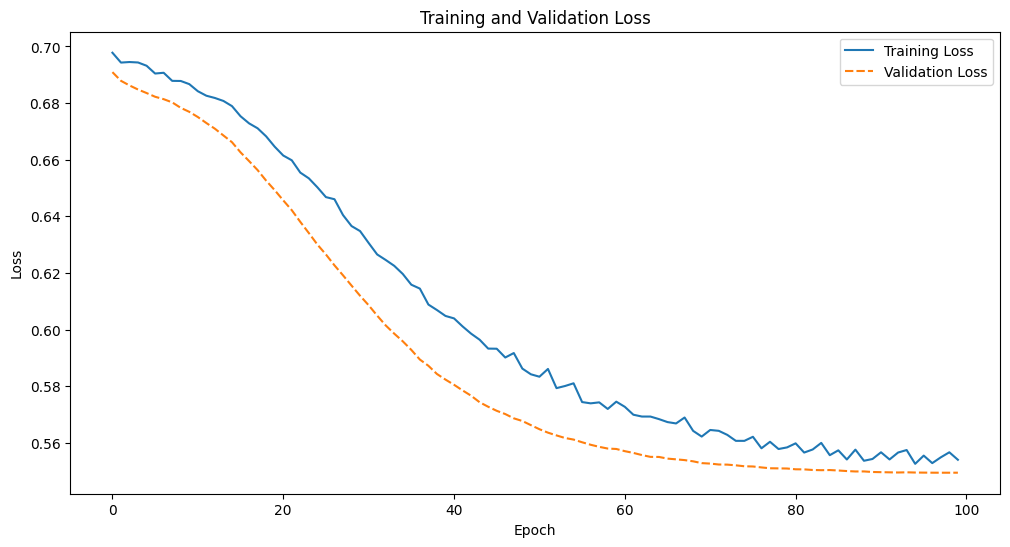

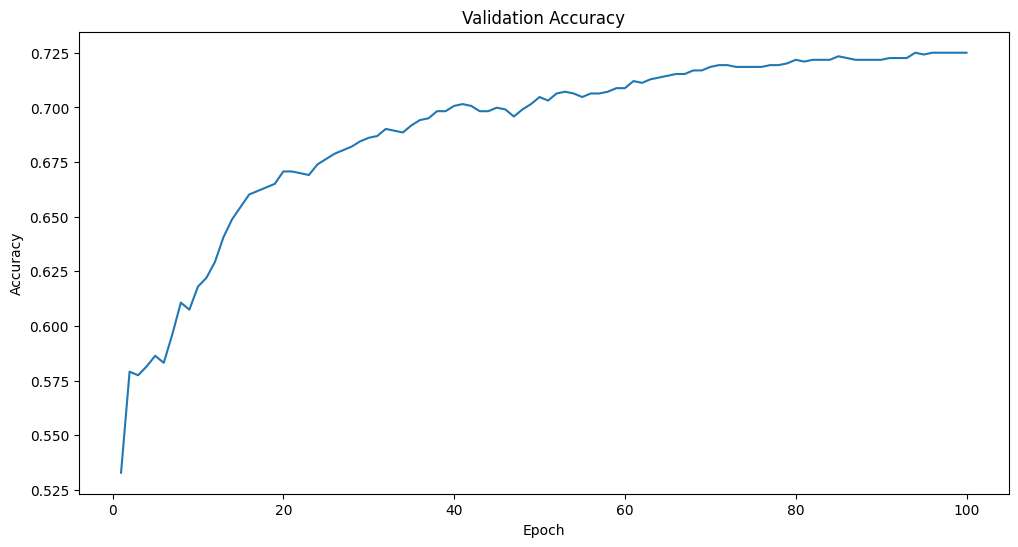

In [183]:
# Plot training stats and evaluation curves
plot_training_stats(training_stats)

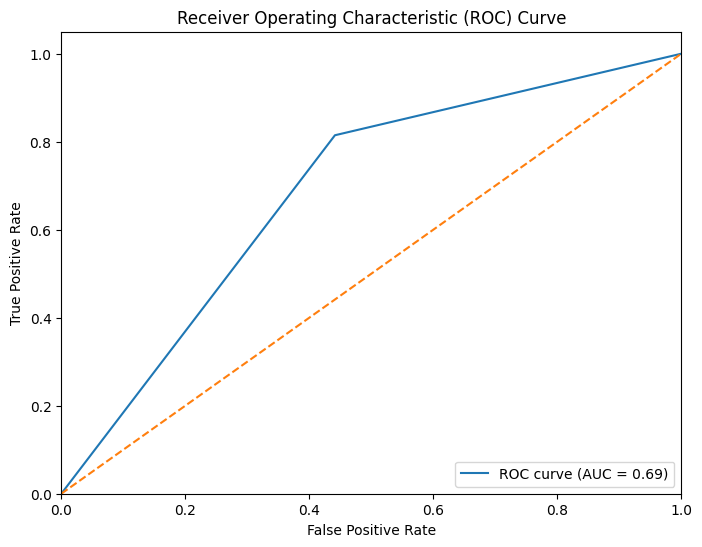

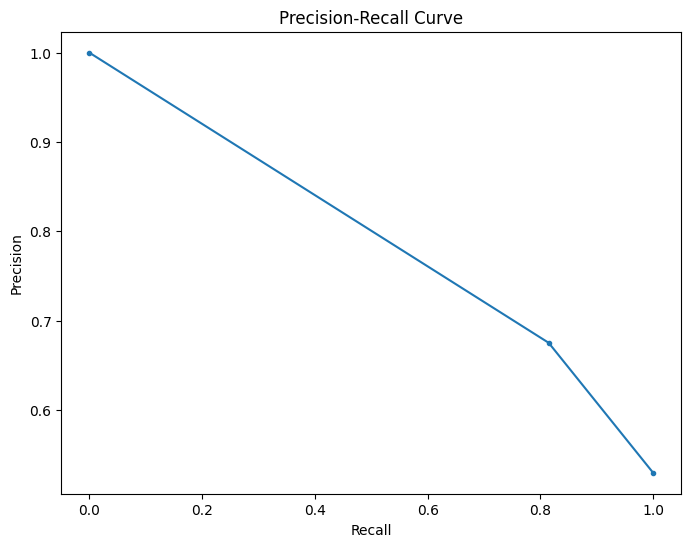

In [184]:
plot_roc_curve(metrics['fpr'], metrics['tpr'], metrics['roc_auc'])
plot_precision_recall_curve(metrics['precision'], metrics['recall'])

In [200]:
# Example prediction
example_text = "This is an application test to show some stats about lol"
prediction = predict(loaded_model, loaded_tokenizer, example_text)
print(f"Prediction for example text: {prediction}")

Prediction for example text: Approved
